# Exponential Smoothing

`Exponential smoothing was proposed in the late 1950s (Brown, 1959; Holt, 1957; Winters, 1960), and has motivated some of the most successful forecasting methods. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight. This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.`

Lecture Notebook by: Sebastian Ibañez, MSc Columbia University <br>
Revamped by: Matthew R. Maulion, MSc

---

## Notebook Outline

1. Simple Exponential Smoothing
2. Methods with Trend
3. Methods with Seasonality
4. Taxonomy of ES Methods
5. Innovations State Space Models for Exponential Smoothing

<b>IMPORTANT NOTES:</b> 
- `statsmodels.tsa.statespace` does NOT support multiplicative models but does automatically calculate prediction intervals. 
- Use `statsmodels.tsa.holtwinters` for multiplicative models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holtwinters_ES  # Multiplicative,  with Trend (trend=True), Seasonality, (seasonal=12)
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing # Additive, with Trend (trend=True), Seasonality, (seasonal=12)

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)


#Baseline Predictions
def meanf(ts, h):
    f = np.mean(ts)
    f = np.repeat(f, repeats=h)
    return f

def naivef(ts, h):
    f = ts[-1]
    f = np.repeat(f, repeats=h)
    return f

def snaivef(ts, h, m):
    f = np.zeros(h)
    for i in range(h):
        f[i] = ts[-(m - i%m)]
    return f

def driftf(ts, h):
    T = len(ts)
    f = np.zeros(h)
    for i in range(h):
        f[i] = ts[-1] + (i+1)*((ts[-1] - ts[0])/(T - 1))
    return f


#Metric Calculation
def mae(y_true, y_pred):
    score = np.mean(np.abs(y_true - y_pred))
    return score

def rmse(y_true, y_pred):
    score = np.sqrt(np.mean((y_true - y_pred)**2))
    return score

def mape(y_true, y_pred):
    score = np.mean(np.abs((y_true - y_pred)/y_true))
    return score

def mase(y_true, y_pred, ts):
    score = np.mean(np.abs((y_true - y_pred)/np.mean(np.abs(ts[1:] - ts[:-1]))))
    return score

def rmsse(y_true, y_pred, ts):
    score = np.sqrt(np.mean(((y_true - y_pred)/np.mean(np.abs(ts[1:] - ts[:-1])))**2))
    return score

def mase_sea(y_true, y_pred, ts, m):
    score = np.mean(np.abs((y_true - y_pred)/np.mean(np.abs(ts[m:] - ts[:-m]))))
    return score

---

## 1. Simple Exponential Smoothing

The <b><i>simple exponential smoothing</b></i> (SES) method produces a one-step ahead forecasts of the form:

\begin{align*}
    \hat{y}_{T+1} &= \alpha y_{T} + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + \cdots
\end{align*}

where $0 \leq \alpha \leq 1$ is a smoothing parameter. In this formulation, the forecast is an exponentially decaying weighted average of <i>all</i> the observations in the series $y_1, \ldots, y_T$.

For illustration, the table below shows the weights attached to observations for four different values of $\alpha$:

<table>
<thead>
<tr class="header">
<th align="left"></th>
<th align="right"><span class="math inline">\(\alpha=0.2\)</span></th>
<th align="right"><span class="math inline">\(\alpha=0.4\)</span></th>
<th align="right"><span class="math inline">\(\alpha=0.6\)</span></th>
<th align="right"><span class="math inline">\(\alpha=0.8\)</span></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td align="left"><span class="math inline">\(y_{T}\)</span></td>
<td align="right">0.2000</td>
<td align="right">0.4000</td>
<td align="right">0.6000</td>
<td align="right">0.8000</td>
</tr>
<tr class="even">
<td align="left"><span class="math inline">\(y_{T-1}\)</span></td>
<td align="right">0.1600</td>
<td align="right">0.2400</td>
<td align="right">0.2400</td>
<td align="right">0.1600</td>
</tr>
<tr class="odd">
<td align="left"><span class="math inline">\(y_{T-2}\)</span></td>
<td align="right">0.1280</td>
<td align="right">0.1440</td>
<td align="right">0.0960</td>
<td align="right">0.0320</td>
</tr>
<tr class="even">
<td align="left"><span class="math inline">\(y_{T-3}\)</span></td>
<td align="right">0.1024</td>
<td align="right">0.0864</td>
<td align="right">0.0384</td>
<td align="right">0.0064</td>
</tr>
<tr class="odd">
<td align="left"><span class="math inline">\(y_{T-4}\)</span></td>
<td align="right">0.0819</td>
<td align="right">0.0518</td>
<td align="right">0.0154</td>
<td align="right">0.0013</td>
</tr>
<tr class="even">
<td align="left"><span class="math inline">\(y_{T-5}\)</span></td>
<td align="right">0.0655</td>
<td align="right">0.0311</td>
<td align="right">0.0061</td>
<td align="right">0.0003</td>
</tr>
</tbody>
</table>

Essentially, as $\alpha \rightarrow 1$ more weight is given to the present and as $\alpha \rightarrow 0$ more weight is given to the past.

### SES Parameters

Notice that we can re-write the SES equation above in terms of fitted values and in recursive form:

\begin{align*}
    \hat{y}_{t+1} &= \alpha y_{t} + (1-\alpha) \hat{y}_{t}
\end{align*}

where $t = 1, 2, \ldots, T$. Since the process has to start from somewhere, we can write the very first SES forecast as:

\begin{align*}
    \hat{y}_{2} &= \alpha y_{1} + (1-\alpha) \hat{y}_{1} \\
    &= \alpha y_{1} + (1-\alpha) \ell_0
\end{align*}

Since there are no values before $y_1$, we can treat $\hat{y}_{1} = \ell_0$ as a parameter.

In summary, the SES method has two parameters: the <b><i>smoothing parameter</b></i> $\alpha$ and the <b><i>initial level</b></i> $\ell_0$. 

These parameters can either be set manually or optimized. In the case of optimization, we can treat the parameter estimation as a curve-fitting problem and minimize the sum of squared errors (SSE).

### Weighted Average Form

\begin{align*}
    \hat{y}_{T+1} &= \sum_{j=0}^{T-1} \alpha(1-\alpha)^j y_{T-j} + (1-\alpha)^T\ell_0
\end{align*}

### Component Form

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+1} &= \ell_t \\
    \text{Smoothing Equation:} && \ell_t &= \alpha y_t + (1-\alpha) \ell_{t-1}
\end{align*}

#### Example: Oil Production

The figure below shows the oil production in Saudi Arabia from 1996 to 2013.

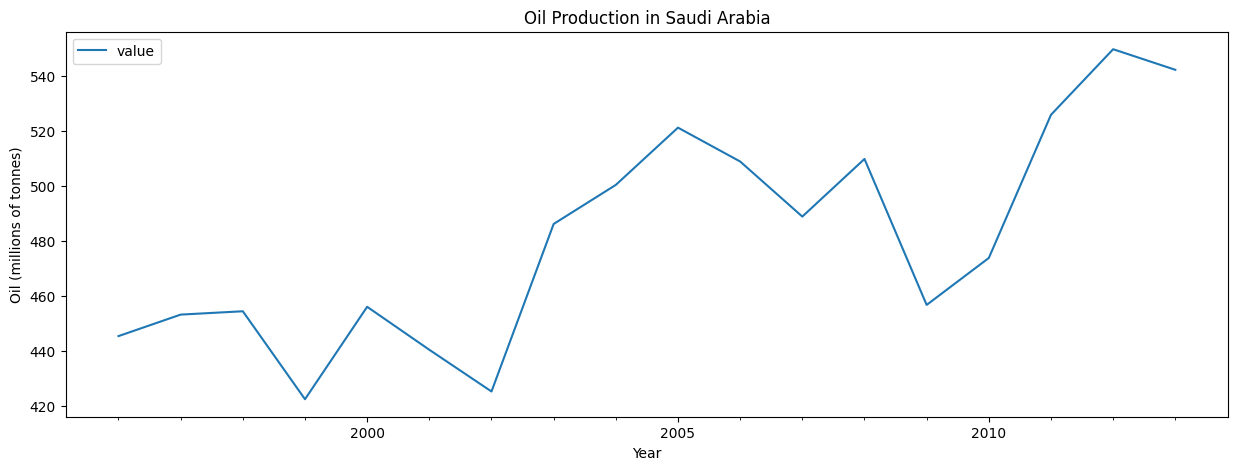

In [6]:
df = pd.read_csv('datasets/oil.csv', index_col=0).iloc[31:]
df.index = pd.period_range(start='1996', periods=18, freq='Y')

ax = df.plot(figsize=(15,5))
ax.set_title('Oil Production in Saudi Arabia')
ax.set_xlabel('Year')
ax.set_ylabel('Oil (millions of tonnes)')
ax.autoscale()
plt.show()

**Predictions**

/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimize

alpha=0.2000 ; l_0=445.36
alpha=0.4000 ; l_0=445.36
alpha=0.6000 ; l_0=445.36
alpha=0.8338 ; l_0=446.58


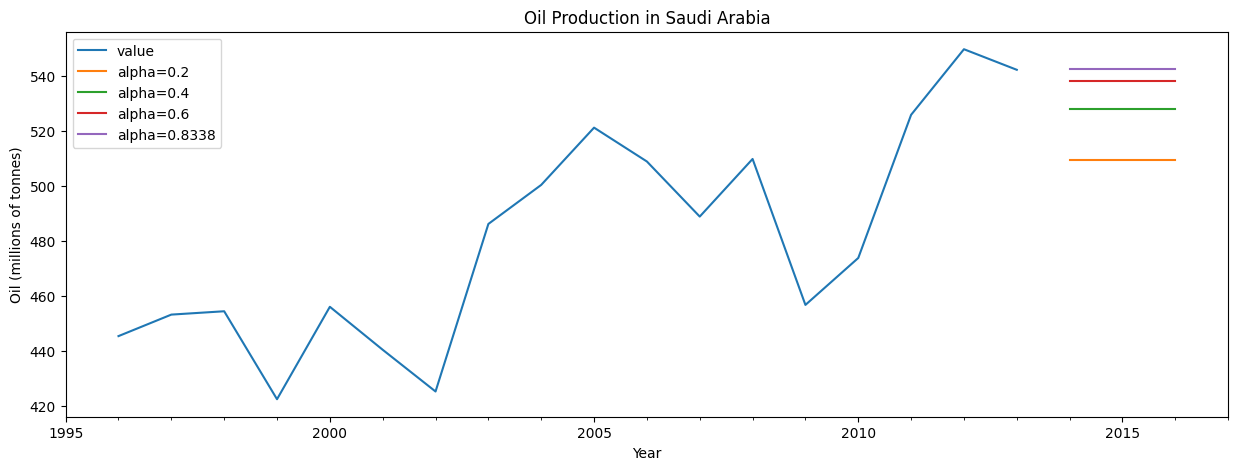

In [7]:
alpha_levels = [0.2, 0.4, 0.6]

ax = df.plot(figsize=(15,5))
for a in alpha_levels:
    model = SimpleExpSmoothing(df).fit(smoothing_level=a)
    forecast = model.forecast(3).rename('alpha=%s' % a)
    print('alpha=%.4f ; l_0=%.2f' % (model.params['smoothing_level'], model.params['initial_level']))
    forecast.plot()
    
model = ExponentialSmoothing(df).fit(optimized=True)
forecast = model.forecast(3).rename('alpha=%.4f' % model.params['smoothing_level'])
print('alpha=%.4f ; l_0=%.2f' % (model.params['smoothing_level'], model.params['initial_level']))

forecast.plot()
ax.set_title('Oil Production in Saudi Arabia')
ax.set_xlabel('Year')
ax.set_ylabel('Oil (millions of tonnes)')
ax.autoscale()
ax.legend()
plt.show()

**Evaluating Predictions**

/tmp/ipykernel_1522440/2061559020.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[i] = ts[-1] + (i+1)*((ts[-1] - ts[0])/(T - 1))
/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


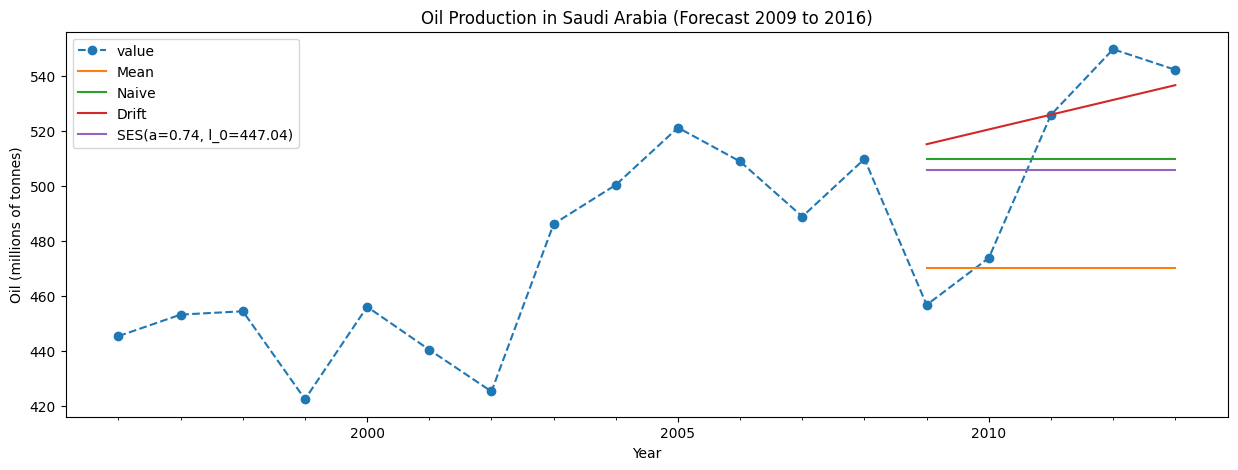

,RMSE,MAE,MAPE,MASE,RMSSE
Mean Method,54.50,44.92,8.42,2.11,2.56
Naive Method,37.51,35.54,7.11,1.67,1.76
Drift,34.61,25.89,5.42,1.22,1.63
SES Optimized,37.70,36.34,7.21,1.71,1.77


In [8]:
### TRAIN-TEST SPLIT
test_size = 5
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

### FORECAST
h = test_size
df_f = pd.DataFrame()
df_f['Mean'] = meanf(df_train.to_numpy(), h=h)
df_f['Naive'] = naivef(df_train.to_numpy(), h=h)
df_f['Drift'] = driftf(df_train.to_numpy(), h=h)

model = ExponentialSmoothing(df_train).fit(optimized=True)
df_f['SES(a=%.2f, l_0=%.2f)' % (model.params['smoothing_level'], model.params['initial_level'])] = model.forecast(h).to_numpy()

df_f.index = pd.period_range(start=df_test.index[0], periods=h, freq='Y')

### PLOT FORECASTS
fig, ax = plt.subplots(figsize=(15,5))
df.plot(ax=ax, legend=False, style='o--')
df_f.plot(ax=ax)
ax.set_title('Oil Production in Saudi Arabia (Forecast 2009 to 2016)')
ax.set_xlabel('Year')
ax.set_ylabel('Oil (millions of tonnes)')
ax.autoscale()
ax.legend()
plt.show()

### EVAL METRICS
df_acc = pd.DataFrame()
rmse_list = []
mae_list = []
mape_list = []
mase_list = []
rmsse_list = []
for col in df_f:
    rmse_list.append(rmse(df_test.value.to_numpy(), df_f[col].to_numpy()))
    mae_list.append(mae(df_test.value.to_numpy(), df_f[col].to_numpy()))
    mape_list.append(mape(df_test.value.to_numpy(), df_f[col].to_numpy())*100)
    mase_list.append(mase(df_test.value.to_numpy(), df_f[col].to_numpy(), df_train.value.to_numpy()))
    rmsse_list.append(rmsse(df_test.value.to_numpy(), df_f[col].to_numpy(), df_train.value.to_numpy()))
df_acc['RMSE'] = np.asarray(rmse_list)
df_acc['MAE'] = np.asarray(mae_list)
df_acc['MAPE'] = np.asarray(mape_list)
df_acc['MASE'] = np.asarray(mase_list)
df_acc['RMSSE'] = np.asarray(rmsse_list)

df_acc.index = ['Mean Method', 'Naive Method', 'Drift', 'SES Optimized']
df_acc

---

## 2. Methods with Trend

### Holt's Linear Trend Method

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+h} &= \ell_t + hb_t \\
    \text{Level Equation:} && \ell_t &= \alpha y_t + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\
    \text{Trend Equation:} && b_t &= \beta^* (\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}
\end{align*}

where $\ell_t$ denotes an estimate of the level of the series, $b_t$ denotes an estimate of the trend (or slope) of the series, $0 \leq \alpha \leq 1$ is the smoothing parameter for the level, and $0 \leq \beta^* \leq 1$ is the smoothing parameter for the trend. 

We note that $\beta^*$ is used instead of $\beta$ because the latter is reserved for a more general form of this model.

### Damped Trend Method

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+h} &= \ell_t + (\phi + \phi^2 + \ldots + \phi^h)b_t \\
    \text{Level Equation:} && \ell_t &= \alpha y_t + (1-\alpha) (\ell_{t-1} + \phi b_{t-1}) \\
    \text{Trend Equation:} && b_t &= \beta^* (\ell_{t} - \ell_{t-1}) + (1 - \beta^*)\phi b_{t-1}
\end{align*}

where $0 < \phi < 1$ is a damping parameter. If $\phi = 1$, the method is identical to Holt's linear trend method. Else, $\phi$ dampens the trend so that it approaches a constant some time in the future.

In practice, we usually restrict $\phi$ to be somewhere between a minimum of $0.8$ and $0.98$ as the damping has a very strong effect for smaller values and the model becomes indistinguishable from a non-damped model as $\phi \rightarrow 1$.

#### Example: Air Passengers

The figure below shows the total annual passengers of air carriers registered in Australia (millions of passengers, 1970–2016).

/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(
/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.

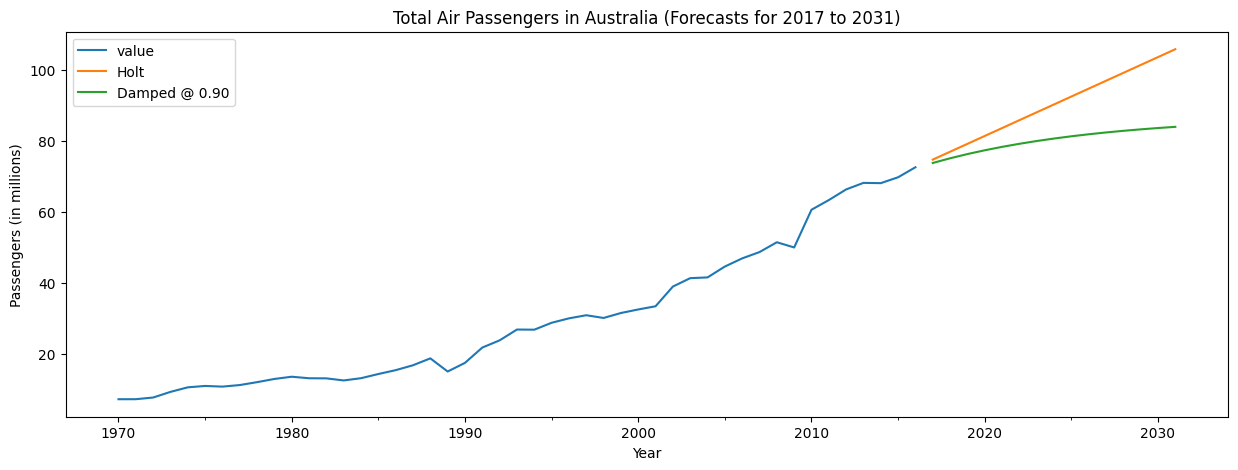

In [9]:
df = pd.read_csv('datasets/ausair.csv', index_col=0)
df.index = pd.period_range(start='1970', periods=47, freq='Y')

ax = df.plot(figsize=(15,5))

#HOLT
model = ExponentialSmoothing(df, trend=True).fit(optimized=True)

#predict 15 years after
forecast = model.forecast(15).rename('Holt')
forecast.plot()

#Damped
damping_trend = 0.9
model = ExponentialSmoothing(df, trend=True, damped_trend=True)
with model.fix_params({'damping_trend': damping_trend}):
        model = model.fit(optimized=True)
forecast = model.forecast(15).rename('Damped @ %.2f' % damping_trend)
forecast.plot()

ax.set_title('Total Air Passengers in Australia (Forecasts for 2017 to 2031)')
ax.set_xlabel('Year')
ax.set_ylabel('Passengers (in millions)')
ax.autoscale()
ax.legend()
plt.show()

/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(


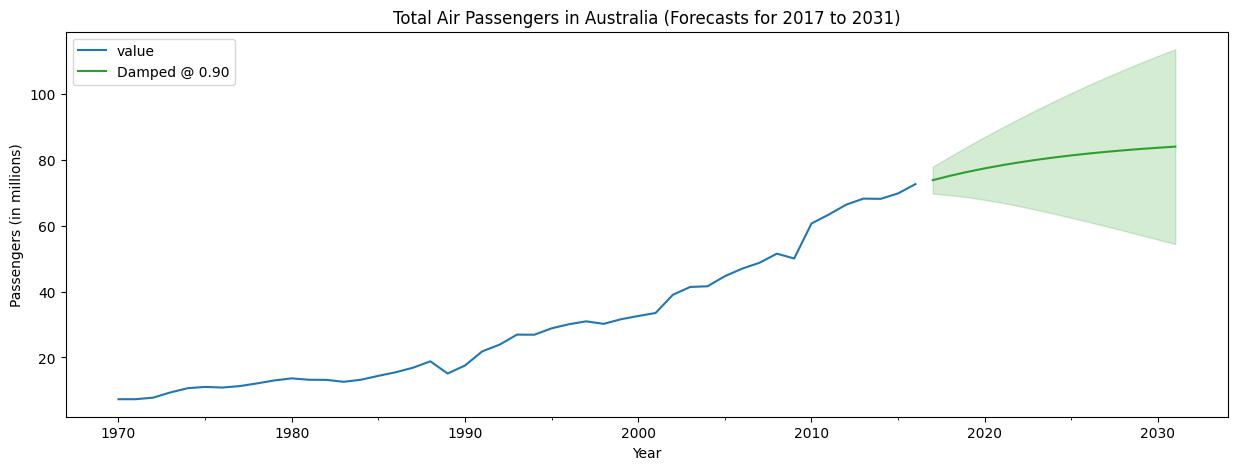

In [10]:
#Damped with Intervals 
ax = df.plot(figsize=(15,5))

damping_trend = 0.9
model = ExponentialSmoothing(df, trend=True, damped_trend=True)
with model.fix_params({'damping_trend': damping_trend}):
        model = model.fit(optimized=True)
forecast = model.forecast(15).rename('Damped @ %.2f' % damping_trend)
forecast.plot(color = 'tab:green')

alpha = 0.05
df_pi = model.get_forecast(15).conf_int(alpha=alpha)
ax.fill_between(forecast.index, df_pi['lower value'], df_pi['upper value'], color = 'tab:green', alpha = 0.2)

ax.set_title('Total Air Passengers in Australia (Forecasts for 2017 to 2031)')
ax.set_xlabel('Year')
ax.set_ylabel('Passengers (in millions)')
ax.autoscale()
ax.legend(loc='upper left')
plt.show()

---

## 2. Methods with Seasonality

### Holt-Winters' Method

#### Additive Version

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+h} &= \ell_t + hb_t + s_{t+h-m(k+1)} \\
    \text{Level Equation:} && \ell_t &= \alpha (y_t - s_{t-m}) + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\
    \text{Trend Equation:} && b_t &= \beta^* (\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1} \\
    \text{Seasonal Equation:} && s_t &= \gamma (y_t - \ell_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m} \\
\end{align*}

where $k$ is the integer part of $(h-1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final year of the sample. Similar to the formulations above, the new parameter $0 \leq \gamma \leq 1-\alpha$ is the smoothing parameter for the seasonal component.

#### Multiplicative Version

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+h} &= (\ell_t + hb_t)s_{t+h-m(k+1)} \\
    \text{Level Equation:} && \ell_t &= \alpha \frac{y_t}{s_{t-m}} + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\
    \text{Trend Equation:} && b_t &= \beta^* (\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1} \\
    \text{Seasonal Equation:} && s_t &= \gamma \frac{y_t}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m} \\
\end{align*}

#### Damped Multiplicative Version

\begin{align*}
    \text{Forecast Equation:} && \hat{y}_{t+h} &= [\ell_t + (\phi + \phi^2 + \ldots + \phi^h)b_t]s_{t+h-m(k+1)} \\
    \text{Level Equation:} && \ell_t &= \alpha \frac{y_t}{s_{t-m}} + (1-\alpha) (\ell_{t-1} + \phi b_{t-1}) \\
    \text{Trend Equation:} && b_t &= \beta^* (\ell_{t} - \ell_{t-1}) + (1 - \beta^*)\phi b_{t-1} \\
    \text{Seasonal Equation:} && s_t &= \gamma \frac{y_t}{(\ell_{t-1} + \phi b_{t-1})} + (1 - \gamma)s_{t-m} \\
\end{align*}

Note that an damped additive version also exists but is omitted for brevity.

#### Example: International Visitor Nights

The figure below shows quarterly visitor nights in Australia spent by international tourist from 1999, and the forecasts for 2016–2017. The data show an obvious seasonal pattern, with peaks observed in the March quarter of each year, corresponding to the Australian summer.

**Predictions**

/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(
/tmp/ipykernel_1522440/2061559020.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[i] = ts[-(m - i%m)]


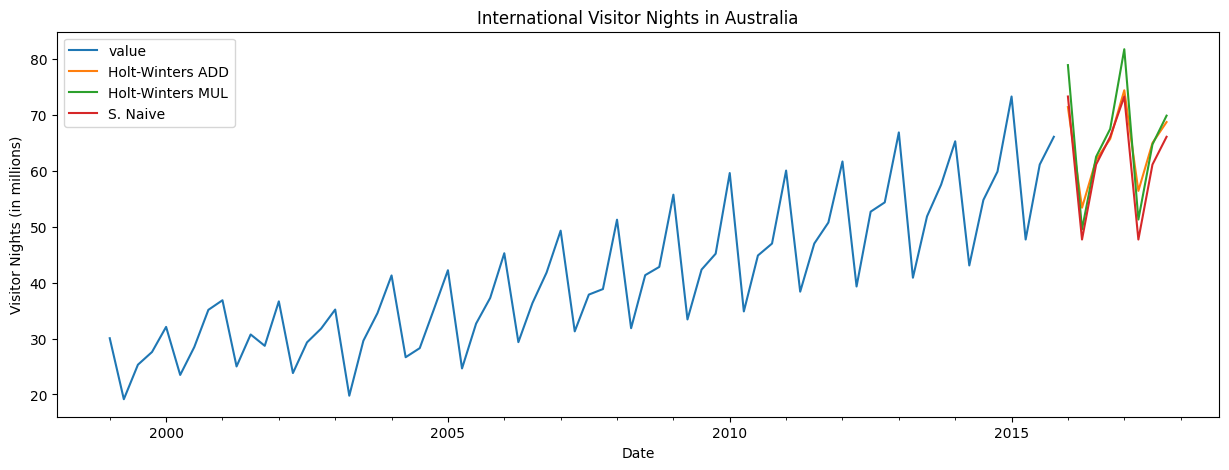

In [11]:
df = pd.read_csv('datasets/austourists.csv', index_col=0)
df.index = pd.period_range(start='1999Q1', periods=68, freq='Q')

ax = df.plot(figsize=(15,5))

h = 8 #number of obervations forecasts
m = 4 #seasonal component (quarter)

df_f = pd.DataFrame()

#Holt Wint ADD
model = ExponentialSmoothing(df, trend=True, seasonal=m).fit(optimized=True, maxiter=100) #Try maxiter=100 for convergence
df_f['Holt-Winters ADD'] = model.forecast(h).to_numpy()

#Holt Wint MUL
model = holtwinters_ES(df, trend='add', seasonal='mul', seasonal_periods=m).fit(optimized=True)
df_f['Holt-Winters MUL'] = model.forecast(h).to_numpy()

#Seasoal Naive
df_f['S. Naive'] = snaivef(df.to_numpy(), h=h, m=m)
df_f.index = pd.period_range(start='2016Q1', periods=h, freq='Q')

df_f.plot(ax=ax)

ax.set_title('International Visitor Nights in Australia')
ax.set_xlabel('Date')
ax.set_ylabel('Visitor Nights (in millions)')
ax.autoscale()
ax.legend()
plt.show()

**Evaluating Predictions**

/home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.venv/lib/python3.12/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: optimized. After release 0.14, this will raise.
  warnings.warn(
/tmp/ipykernel_1522440/2061559020.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[i] = ts[-(m - i%m)]


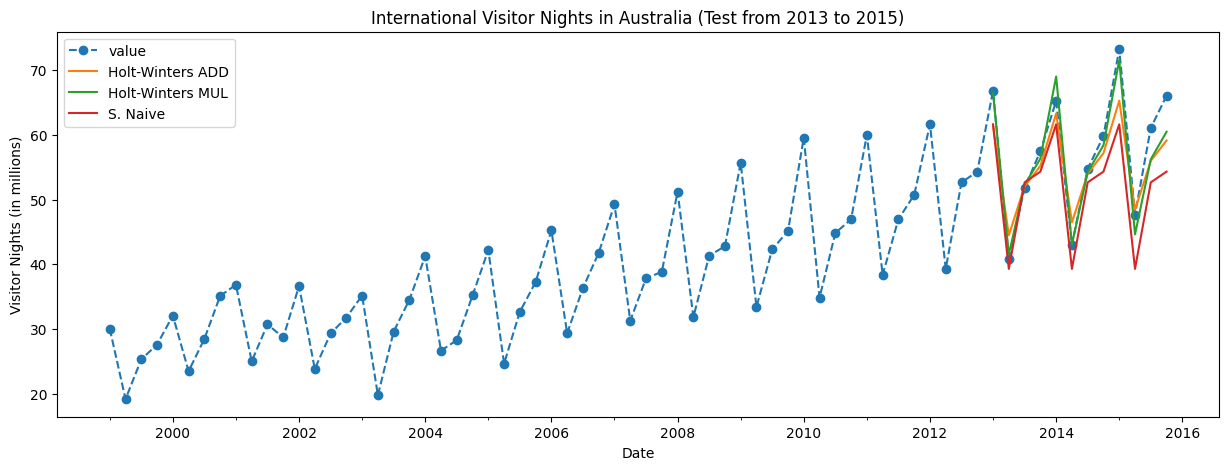

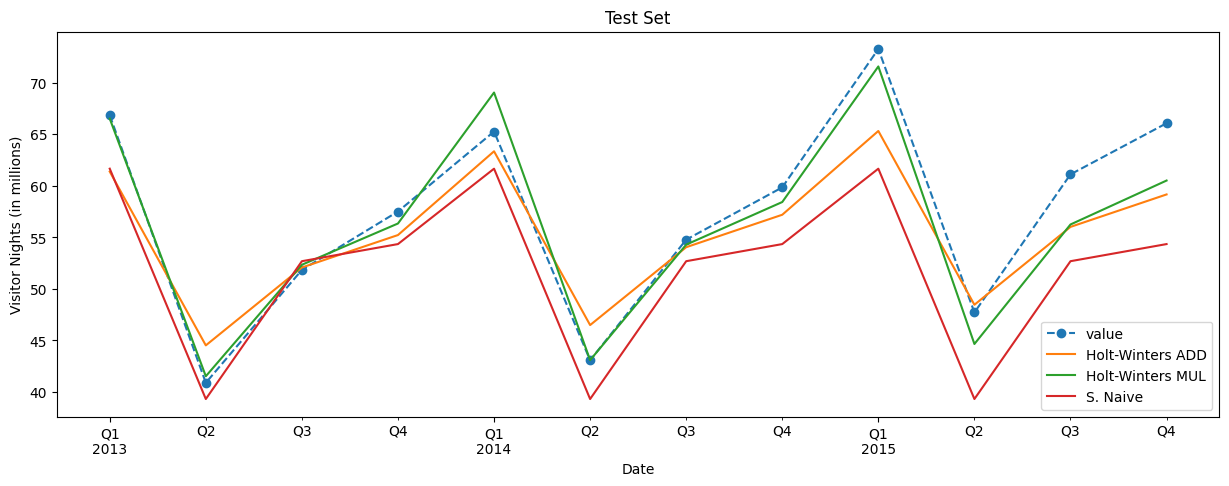

,RMSE,MAE,MAPE,MASE_SEA
Holt-Winters ADD,4.17,3.42,5.78,1.20
Holt-Winters MUL,2.67,1.96,3.27,0.69
S.Naive,6.55,5.49,9.25,1.93


In [12]:
### TRAIN-TEST SPLIT
test_size = 12
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

### FORECAST
h = test_size
m = 4

df_f = pd.DataFrame()

model = ExponentialSmoothing(df_train, trend=True, seasonal=m).fit(optimized=True)
df_f['Holt-Winters ADD'] = model.forecast(h).to_numpy()

model = holtwinters_ES(df_train, trend='add', seasonal='mul', seasonal_periods=m).fit(optimized=True)
df_f['Holt-Winters MUL'] = model.forecast(h).to_numpy()

df_f['S. Naive'] = snaivef(df_train.to_numpy(), h=h, m=m)

df_f.index = df_test.index

### PLOT FORECASTS

#TRAIN + TEST Set Metrics
fig, ax = plt.subplots(figsize=(15,5))
df.plot(ax=ax, legend=False, style='o--')
df_f.plot(ax=ax)
ax.set_title('International Visitor Nights in Australia (Test from 2013 to 2015)')
ax.set_xlabel('Date')
ax.set_ylabel('Visitor Nights (in millions)')
ax.autoscale()
ax.legend()
plt.show()

#TEST Set Metrics
fig, ax = plt.subplots(figsize=(15,5))
df_test.plot(ax=ax, legend=False, style='o--')
df_f.plot(ax=ax)
ax.set_title('Test Set')
ax.set_xlabel('Date')
ax.set_ylabel('Visitor Nights (in millions)')
ax.autoscale()
ax.legend()
plt.show()

### EVAL METRICS
df_acc = pd.DataFrame()
rmse_list = []
mae_list = []
mape_list = []
mase_list = []
for col in df_f:
    rmse_list.append(rmse(df_test.value.to_numpy(), df_f[col].to_numpy()))
    mae_list.append(mae(df_test.value.to_numpy(), df_f[col].to_numpy()))
    mape_list.append(mape(df_test.value.to_numpy(), df_f[col].to_numpy())*100)
    mase_list.append(mase_sea(df_test.value.to_numpy(), df_f[col].to_numpy(), df_train.value.to_numpy(), m=m))
df_acc['RMSE'] = np.asarray(rmse_list)
df_acc['MAE'] = np.asarray(mae_list)
df_acc['MAPE'] = np.asarray(mape_list)
df_acc['MASE_SEA'] = np.asarray(mase_list)

df_acc.index = ['Holt-Winters ADD', 'Holt-Winters MUL', 'S.Naive']
df_acc

---

## 4. Taxonomy of ES Methods

A two-way classification of exponential smoothing methods:

<table>
<thead>
<tr>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: left; " colspan="1">
<div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">
Trend Component
</div>
</th>
<th style="border-bottom:hidden;padding-bottom:0; padding-left:3px;padding-right:3px;text-align: left; " colspan="3">
<div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">
Seasonal Component
</div>
</th>
</tr>
<tr>
<th style="text-align:left;background-color: #e6e6e6 !important;">
</th>
<th style="text-align:left;background-color: #e6e6e6 !important;">
N
</th>
<th style="text-align:left;background-color: #e6e6e6 !important;">
A
</th>
<th style="text-align:left;background-color: #e6e6e6 !important;">
M
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;font-weight: bold;background-color: #e6e6e6 !important;font-weight: bold;background-color: #e6e6e6 !important;">
</td>
<td style="text-align:left;font-weight: bold;background-color: #e6e6e6 !important;">
(None)
</td>
<td style="text-align:left;font-weight: bold;background-color: #e6e6e6 !important;">
(Additive)
</td>
<td style="text-align:left;font-weight: bold;background-color: #e6e6e6 !important;">
(Multiplicative)
</td>
</tr>
<tr>
<td style="text-align:left;background-color: #f6f6f6 !important;font-weight: bold;background-color: #e6e6e6 !important;">
N (None)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(N,N)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(N,A)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(N,M)
</td>
</tr>
<tr>
<td style="text-align:left;background-color: #f6f6f6 !important;font-weight: bold;background-color: #e6e6e6 !important;">
A (Additive)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A,N)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A,A)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A,M)
</td>
</tr>
<tr>
<td style="text-align:left;background-color: #f6f6f6 !important;font-weight: bold;background-color: #e6e6e6 !important;">
A<span class="math inline">\(_d\)</span> (Additive damped)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A<span class="math inline">\(_d\)</span>,N)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A<span class="math inline">\(_d\)</span>,A)
</td>
<td style="text-align:left;background-color: #f6f6f6 !important;">
(A<span class="math inline">\(_d\)</span>,M)
</td>
</tr>
</tbody>
</table>

Some of these methods we have already seen using other names:

<table>
<thead>
<tr>
<th style="text-align:left;">
Short hand
</th>
<th style="text-align:left;">
Method
</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left;">
(N,N)
</td>
<td style="text-align:left;">
Simple exponential smoothing
</td>
</tr>
<tr>
<td style="text-align:left;">
(A,N)
</td>
<td style="text-align:left;">
Holt’s linear method
</td>
</tr>
<tr>
<td style="text-align:left;">
(A<span class="math inline">\(_d\)</span>,N)
</td>
<td style="text-align:left;">
Additive damped trend method
</td>
</tr>
<tr>
<td style="text-align:left;">
(A,A)
</td>
<td style="text-align:left;">
Additive Holt-Winters’ method
</td>
</tr>
<tr>
<td style="text-align:left;">
(A,M)
</td>
<td style="text-align:left;">
Multiplicative Holt-Winters’ method
</td>
</tr>
<tr>
<td style="text-align:left;">
(A<span class="math inline">\(_d\)</span>,M)
</td>
<td style="text-align:left;">
Holt-Winters’ damped method
</td>
</tr>
</tbody>
</table>

The methods above constitute the TS part of a class of methods called ETS (Error-Trend-Seasonality).

The summary of the formulas for the recursive equations can be found in [FPP3](https://otexts.com/fpp3/taxonomy.html).

---

## 5. Innovations State Space Models for Exponential Smoothing

The previously discussed exponential smoothing methods are used to generate <i>point forecasts</i>. Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the <i>unobserved</i> components or states (level, trend, seasonal) change over time. Hence, these are referred to as <b><i>state space models</b></i>. 

The methods in this section generate the same point forecasts, but can also generate prediction intervals. Specifically, these models are formulated as full statistical models. Thus, are capable of producing an entire forecast distribution.

For each exponential smoothing method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals. We call these class of models <b><i>innovations state space models</b></i> (for exponential smoothing) or <b><i>ETS models</b></i> (Error, Trend, Seasonal).

For notation, we will use $\text{ETS}(\cdot, \cdot, \cdot)$ to parametrize these models, where $\text{Error} = \{\text{A}, \text{M}\}$, $\text{Trend} = \{\text{N}, \text{A}, \text{A}_d\}$, and $\text{Seasonal} = \{\text{N}, \text{A}, \text{M}\}$.

See [FPP3](https://otexts.com/fpp3/ets.html) for a full list of the state space equations for each model in the ETS framework.

Some final notes:

- ETS point forecasts are equal to the medians of the forecast distributions
- For models with only additive components, the forecast distributions are normal, so the medians and means are equal.
- For ETS models with multiplicative errors, or with multiplicative seasonality, the point forecasts will not be equal to the means of the forecast distributions.
- The prediction intervals will differ between models with additive and multiplicative methods.

---

## References

Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on Febuary 16, 2021.

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on Febuary 24, 2021.

In [2]:
40 / 46

0.8695652173913043

In [7]:
46 / 40

1.15

In [9]:
10_000 * 0.8695652173913043 * 1.15 + (10_000 * 0.06 * 3)

11800.0

In [6]:
10_000 * 0.06 * 3

1800.0

In [11]:
(113.44 - 108.64) / 365

0.013150684931506841

In [15]:
(113.44 / 108.64) - (148.03 / 141.79)

0.00017387617461195326

In [14]:
148.03 / 141.79

1.0440087453275972